In [1]:
from __future__ import unicode_literals, print_function, division
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from io import open
import unicodedata
import string
import re
import random
import time
import math
import json
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import numpy as np
from os import system
from nltk.translate.bleu_score import SmoothingFunction, sentence_bleu
#plt.switch_backend('agg')

In [2]:
if torch.cuda.is_available():
    device = 'cuda:0'
    print("[INFO] Current device:", torch.cuda.get_device_name(torch.cuda.current_device()), f", device num:{torch.cuda.current_device()}")
elif torch.has_mps:
    device = 'mps'
    print("[INFO] Current device: MAC OS Metal Performance Shaders.")
else:
    device = 'cpu'
    print("[INFO] Current device: CPU")
    print("*"*50,"\n[WARNING] You may need to change the device to GPU or MPS to get better performance.")
    print("*"*50)
device = torch.device(device)

[INFO] Current device: NVIDIA GeForce RTX 3080 , device num:0


In [3]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [4]:
#compute BLEU-4 score
def compute_bleu(output, reference):
    cc = SmoothingFunction()
    if len(reference) == 3:
        weights = (0.33,0.33,0.33)
    else:
        weights = (0.25,0.25,0.25,0.25)
    return sentence_bleu([reference], output,weights=weights,smoothing_function=cc.method1)

In [5]:
SOS_token = 0
EOS_token = 27
PAD_token = 28
hidden_size = 512
embedding_dim = 256
vocab_size = 29

In [6]:
characters = ['SOS']+[chr(i)for i in range(ord('a'),ord('z')+1)]+['EOS','PAD']
char_to_index = {char: a for a, char in enumerate(characters)}
index_to_char = {i: char for i, char in enumerate(characters)}

In [7]:
class SpellCorrectionDataset(Dataset):
    def __init__(self,data,targets):
        super(SpellCorrectionDataset, self).__init__()
        
        self.data = data
        self.targets = targets
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = torch.tensor(self.data[index],dtype=torch.long)
        y = torch.tensor(self.targets[index],dtype=torch.long)
        return x,y

In [8]:
file_path ='train.json'
with open(file_path, 'r') as file:
            data = json.load(file)
target_list = []
input_list = []
for i in range(len(data)):
    for j in range(len(data[i]['input'])):
        input_list.append(data[i]['input'][j])
        target_list.append(data[i]['target'])
# 字母到數字
letter_to_number = {char: i + 1 for i, char in enumerate(string.ascii_lowercase)}
# 單字到數字
word_to_number = {word: [letter_to_number[char] for char in word] for word in input_list}
# 進行轉換
input_list = [word_to_number[word] for word in input_list]
# 進行padding
input_list = [[SOS_token] + arr for arr in input_list]
input_list = [arr + [EOS_token] for arr in input_list]
input_list = [arr + [PAD_token] * (21-len(arr))for arr in input_list]
# 單字到數字
word_to_number = {word: [letter_to_number[char] for char in word] for word in target_list}
# 進行轉換
target_list = [word_to_number[word] for word in target_list]
# 進行padding
target_list = [[SOS_token] + arr for arr in target_list]
target_list = [arr + [EOS_token] for arr in target_list]
target_list = [arr + [PAD_token] * (21-len(arr))for arr in target_list]
train_X = input_list
train_Y = target_list

In [9]:
file_path ='test.json'
with open(file_path, 'r') as file:
            data = json.load(file)
target_list = []
input_list = []
for i in range(len(data)):
    for j in range(len(data[i]['input'])):
        input_list.append(data[i]['input'][j])
        target_list.append(data[i]['target'])
copy_target = target_list.copy()
copy_input = input_list.copy()
# 字母到數字
letter_to_number = {char: i + 1 for i, char in enumerate(string.ascii_lowercase)}
# 單字到數字
word_to_number = {word: [letter_to_number[char] for char in word] for word in input_list}
# 進行轉換
input_list = [word_to_number[word] for word in input_list]
# 進行padding
input_list = [[SOS_token] + arr for arr in input_list]
input_list = [arr + [EOS_token] for arr in input_list]
input_list = [arr + [PAD_token] * (21-len(arr))for arr in input_list]
# 單字到數字
word_to_number = {word: [letter_to_number[char] for char in word] for word in target_list}
# 進行轉換
target_list = [word_to_number[word] for word in target_list]
# 進行padding
target_list = [[SOS_token] + arr for arr in target_list]
target_list = [arr + [EOS_token] for arr in target_list]
target_list = [arr + [PAD_token] * (21-len(arr))for arr in target_list]
test_X = input_list
test_Y = target_list

In [10]:
file_path ='new_test.json'
with open(file_path, 'r') as file:
            data = json.load(file)
target_list = []
input_list = []
for i in range(len(data)):
    for j in range(len(data[i]['input'])):
        input_list.append(data[i]['input'][j])
        target_list.append(data[i]['target'])
copy_target = target_list.copy()
copy_input = input_list.copy()
# 字母到數字
letter_to_number = {char: i + 1 for i, char in enumerate(string.ascii_lowercase)}
# 單字到數字
word_to_number = {word: [letter_to_number[char] for char in word] for word in input_list}
# 進行轉換
input_list = [word_to_number[word] for word in input_list]
# 進行padding
input_list = [[SOS_token] + arr for arr in input_list]
input_list = [arr + [EOS_token] for arr in input_list]
input_list = [arr + [PAD_token] * (21-len(arr))for arr in input_list]
# 單字到數字
word_to_number = {word: [letter_to_number[char] for char in word] for word in target_list}
# 進行轉換
target_list = [word_to_number[word] for word in target_list]
# 進行padding
target_list = [[SOS_token] + arr for arr in target_list]
target_list = [arr + [EOS_token] for arr in target_list]
target_list = [arr + [PAD_token] * (21-len(arr))for arr in target_list]
new_test_X = input_list
new_test_Y = target_list

In [11]:
trainset = SpellCorrectionDataset(train_X,train_Y)
trainloader = DataLoader(trainset, batch_size=16,shuffle=True)
valset = SpellCorrectionDataset(test_X,test_Y)
valloader = DataLoader(valset, batch_size=16,shuffle=False)
testset = SpellCorrectionDataset(new_test_X,new_test_Y)
testloader = DataLoader(testset, batch_size=16,shuffle=False)

In [12]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN,self).__init__() 
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, embedding_dim)
        self.encoder= nn.LSTM(embedding_dim, hidden_size, num_layers=2, dropout = 0.5)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, src):  
        embedded = self.dropout(self.embedding(src))  
        outputs,hidden = self.encoder(embedded)        
        return outputs, hidden
#outputs:tensor,hidden:tuple

In [13]:
class DecoderRNN(nn.Module):
    def __init__(self,hidden_size,output_size):
        super(DecoderRNN, self).__init__()
        self.output_dim = output_size
        self.hid_dim = hidden_size
        self.embedding = nn.Embedding(output_size, embedding_dim)
        self.decoder = nn.LSTM(embedding_dim, hidden_size, num_layers=2, dropout = 0.5)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(0.5)   
        
    def forward(self, input, hidden):
        input = input.unsqueeze(0)
        embedded = self.dropout(self.embedding(input))         
        d_output, hidden = self.decoder(embedded, hidden)
        prediction = self.fc(d_output.squeeze(0))
        return prediction, hidden

In [14]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        src = torch.transpose(src,0,1)
        trg = torch.transpose(trg,0,1)
        batch_size = trg.shape[1]
        trg_len = trg.shape[0] 
        trg_vocab_size = self.decoder.output_dim
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        output, hidden = self.encoder(src)
        input = trg[0,:]
        
        teacher_force = random.random() < teacher_forcing_ratio

        if(teacher_force==True):
            for t in range(1, trg_len):
                output, hidden = self.decoder(input, hidden)
                outputs[t] = output
                input = trg[t]
            outputs_g = torch.transpose(outputs,0,1)
            return outputs_g
        else:
            for t in range(1, trg_len):
                output, hidden = self.decoder(input, hidden)
                outputs[t] = output
                top1 = output.argmax(1) 
                input=top1
            outputs_g = torch.transpose(outputs,0,1)
            return outputs_g

In [15]:
enc = EncoderRNN(vocab_size, hidden_size)
dec = DecoderRNN(hidden_size, vocab_size)

model = Seq2Seq(enc, dec, device).to(device)
optimizer = optim.SGD(model.parameters(),lr = 0.05)
criterion = nn.CrossEntropyLoss(ignore_index = 28)

In [16]:
def train(model, trainloader, optimizer, criterion, clip):
    
    model.train().to(device)
    
    epoch_loss = 0
    
    for i, data in enumerate(trainloader):

        src = data[0].to(device)
        trg = data[1].to(device)
        optimizer.zero_grad()
        output = model(src, trg)
        output_dim = output.shape[-1]
        output = output[:, 1:, :].reshape(-1, output_dim)
        trg = trg[:,1:].reshape(-1)
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
        
    return epoch_loss / len(trainloader)

In [17]:
def index_to_char_soft(index):
    index_c = []
    for k in range(index.shape[0]):
        softmax_tensor = F.softmax(index[k].float(), dim = 1)
        argmax_indices = torch.argmax(softmax_tensor , dim = 1)
        l = argmax_indices.tolist()
        ll = [item for item in l if item not in [0,27,28]]
        l_c = [index_to_char[char] for char in ll]
        c = ''.join(l_c)
        index_c.append(c)
    return index_c

def index_to_char1(index):
    index_c = []
    for k in range(index.shape[0]):
        l = index[k].tolist()
        ll = [item for item in l if item not in [0,27,28]]
        l_c = [index_to_char[char] for char in ll]
        c = ''.join(l_c)
        index_c.append(c)
    return index_c

In [18]:
def evaluate(model, valloader, criterion,epoch = 0):
    model.eval()
    epoch_loss = 0
    bleu_score = []
    acc = 0
    with torch.no_grad():
        
        for i, data in enumerate(valloader):
            src , trg = data[0].to(device) , data[1].to(device)
            output = model(src ,trg , 0)
            output_dim = output.shape[-1]
            src_c = index_to_char1(src)
            trg_c = index_to_char1(trg)
            output_c = index_to_char_soft(output)
            
            if epoch % 100 == 0:
                print('==========')
                print('src:',src_c)
                print('output:',output_c)
                print('trg',trg_c)
                print('==========')

            for k in range(len(src_c)):
                bleu_score.append(compute_bleu(output_c[k],trg_c[k]))
                if trg_c[k] == output_c[k]:
                    acc+= 1
            output = output[1:].reshape(-1,output_dim)
            trg = trg[1:].reshape(-1)
            loss = criterion(output, trg)
            epoch_loss += loss.item()
            
    return acc/50,np.mean(bleu_score),epoch_loss / len(valloader)

In [19]:
def evaluate2(model, trainloader, criterion,epoch = 0):
    model.eval()
    epoch_loss = 0
    bleu_score = []
    acc = 0
    with torch.no_grad():
        for i, data in enumerate(trainloader):
            src , trg = data[0].to(device) , data[1].to(device)
            output = model(src ,trg , 0)
            output_dim = output.shape[-1]
            src_c = index_to_char1(src)
            trg_c = index_to_char1(trg)
            output_c = index_to_char_soft(output)
            for k in range(len(src_c)):
                bleu_score.append(compute_bleu(output_c[k],trg_c[k]))
                if trg_c[k] == output_c[k]:
                    acc+= 1
            output = output[1:].reshape(-1,output_dim)
            trg = trg[1:].reshape(-1)
            loss = criterion(output, trg)
            epoch_loss += loss.item()
    return acc/50,np.mean(bleu_score),epoch_loss / len(trainloader)

In [20]:
def evaluate3(model, testloader, criterion,epoch = 0):
    model.eval()
    epoch_loss = 0
    bleu_score = []
    acc = 0
    with torch.no_grad():
        for i, data in enumerate(testloader):
            src , trg = data[0].to(device) , data[1].to(device)
            output = model(src ,trg , 0)
            output_dim = output.shape[-1]
            src_c = index_to_char1(src)
            trg_c = index_to_char1(trg)
            output_c = index_to_char_soft(output)

            for k in range(len(src_c)):
                bleu_score.append(compute_bleu(output_c[k],trg_c[k]))
                if trg_c[k] == output_c[k]:
                    acc+= 1
            output = output[1:].reshape(-1,output_dim)
            trg = trg[1:].reshape(-1)
            loss = criterion(output, trg)
            epoch_loss += loss.item()
    return acc/50,np.mean(bleu_score),epoch_loss / len(testloader)

In [22]:
N_EPOCHS = 250
CLIP = 1
early_stop = 60
best_valid_loss = float('inf')
best_acc = 0.0
tr_loss=[]
va_loss=[]
n_loss=[]
bleu_score=[]
new_blue_score=[]
accuracy=[]
new_accuracy=[]

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, trainloader, optimizer, criterion, CLIP)
    acc,bleu,valid_loss = evaluate(model, valloader, criterion,epoch)
    acc_train,bleu_train,valid_loss_train = evaluate2(model, trainloader, criterion,epoch)
    new_acc,new_bleu,new_loss = evaluate3(model, testloader, criterion,epoch)

    tr_loss.append(train_loss)
    va_loss.append(valid_loss)
    n_loss.append(new_loss)
    bleu_score.append(bleu)
    new_blue_score.append(new_bleu)
    new_accuracy.append(new_acc)
    accuracy.append(acc)
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    metrics={
        'train_loss':tr_loss,
        'val_loss':va_loss,
        'bleu_score':bleu_score,
        'accuracy':accuracy,
    }
    torch.save(metrics,'training_metrics.pth')

    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(),'acc.pt')
        print("Save ACC")
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(),'tests_lost.pt')
        j=0
    else:
        j=j+1
        if j == early_stop:
            print("Early Stop")
            break
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} |Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\tTest Loss: {valid_loss:.3f} |Test PPL: {math.exp(valid_loss):7.3f}')
    print(f'\tTest Accuracy: {acc:.3f} |Test Bleu_score: {bleu : 7.3f}')
    print(f'\tNew Test Accuracy: {new_acc:.3f} |New Test Bleu_score: {new_bleu : 7.3f}')

src: ['contenpted', 'begining', 'problam', 'dirven', 'ecstacy', 'juce', 'localy', 'compair', 'pronounciation', 'transportibility', 'miniscule', 'independant', 'aranged', 'poartry', 'leval', 'basicaly']
output: ['aaeeee', 'aaeeee', 'aaeeee', 'aaeeee', 'aaeeee', 'aaeeee', 'aaeeee', 'aaeeee', 'aeeee', 'aeeee', 'aaeeee', 'aaeeee', 'aaeeee', 'aaeeee', 'aaeeee', 'aaeeee']
trg ['contented', 'beginning', 'problem', 'driven', 'ecstasy', 'juice', 'locally', 'compare', 'pronunciation', 'transportability', 'minuscule', 'independent', 'arranged', 'poetry', 'level', 'basically']
src: ['triangulaur', 'unexpcted', 'stanerdizing', 'varable', 'neigbours', 'enxt', 'powerfull', 'practial', 'repatition', 'repentence', 'substracts', 'beed', 'beame', 'decieve', 'decant', 'dag']
output: ['aaeeee', 'aaeeee', 'aeeeee', 'aaeeee', 'aaeeee', 'aaeeee', 'aaeeee', 'aaeeee', 'aaeeee', 'aaeeee', 'aaeeee', 'aaeeee', 'aaeeee', 'aaeeee', 'aaeeee', 'aaeeee']
trg ['triangular', 'unexpected', 'standardizing', 'variable', 'ne

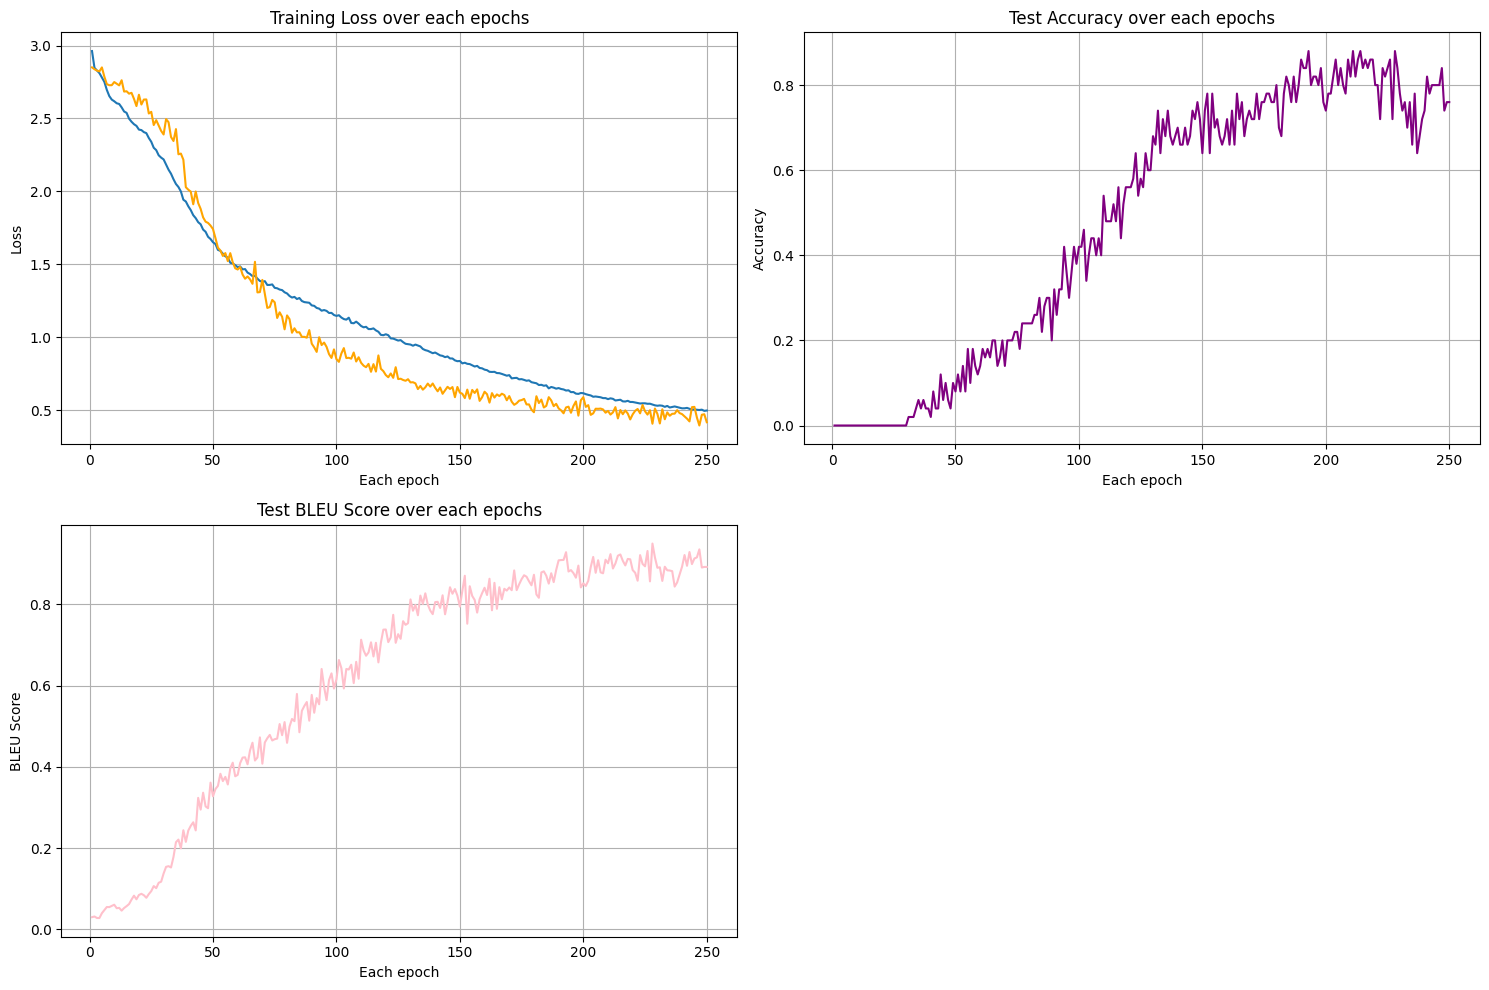

In [23]:
%matplotlib inline

# 第一個表 (Training Loss,Validation Loss)
plt.figure(figsize=(15, 10))
train_losses = [round(num, 5) for num in tr_loss]
plt.subplot(2, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, linestyle='-',label='Training Loss')
plt.plot(range(1, len(va_loss) + 1), va_loss, linestyle='-', color='orange', label='Validation Loss')
plt.xlabel('Each epoch')
plt.ylabel('Loss')
plt.title('Training Loss over each epochs')
plt.grid()

# 第二個表 (Test Accuracy)
plt.subplot(2, 2, 2)
plt.plot(range(1, len(accuracy) + 1), accuracy, linestyle='-', color='purple')
plt.xlabel('Each epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy over each epochs')
plt.grid()

# 第三個表 (Test BLEU)
plt.subplot(2, 2, 3)
plt.plot(range(1, len(new_blue_score) + 1), new_blue_score, linestyle='-', color='pink')
plt.xlabel('Each epoch')
plt.ylabel('New BLEU Score')
plt.title('Test BLEU Score over each epochs')
plt.grid()

plt.tight_layout()  # 自動調整子圖的間距，防止重疊
plt.show()

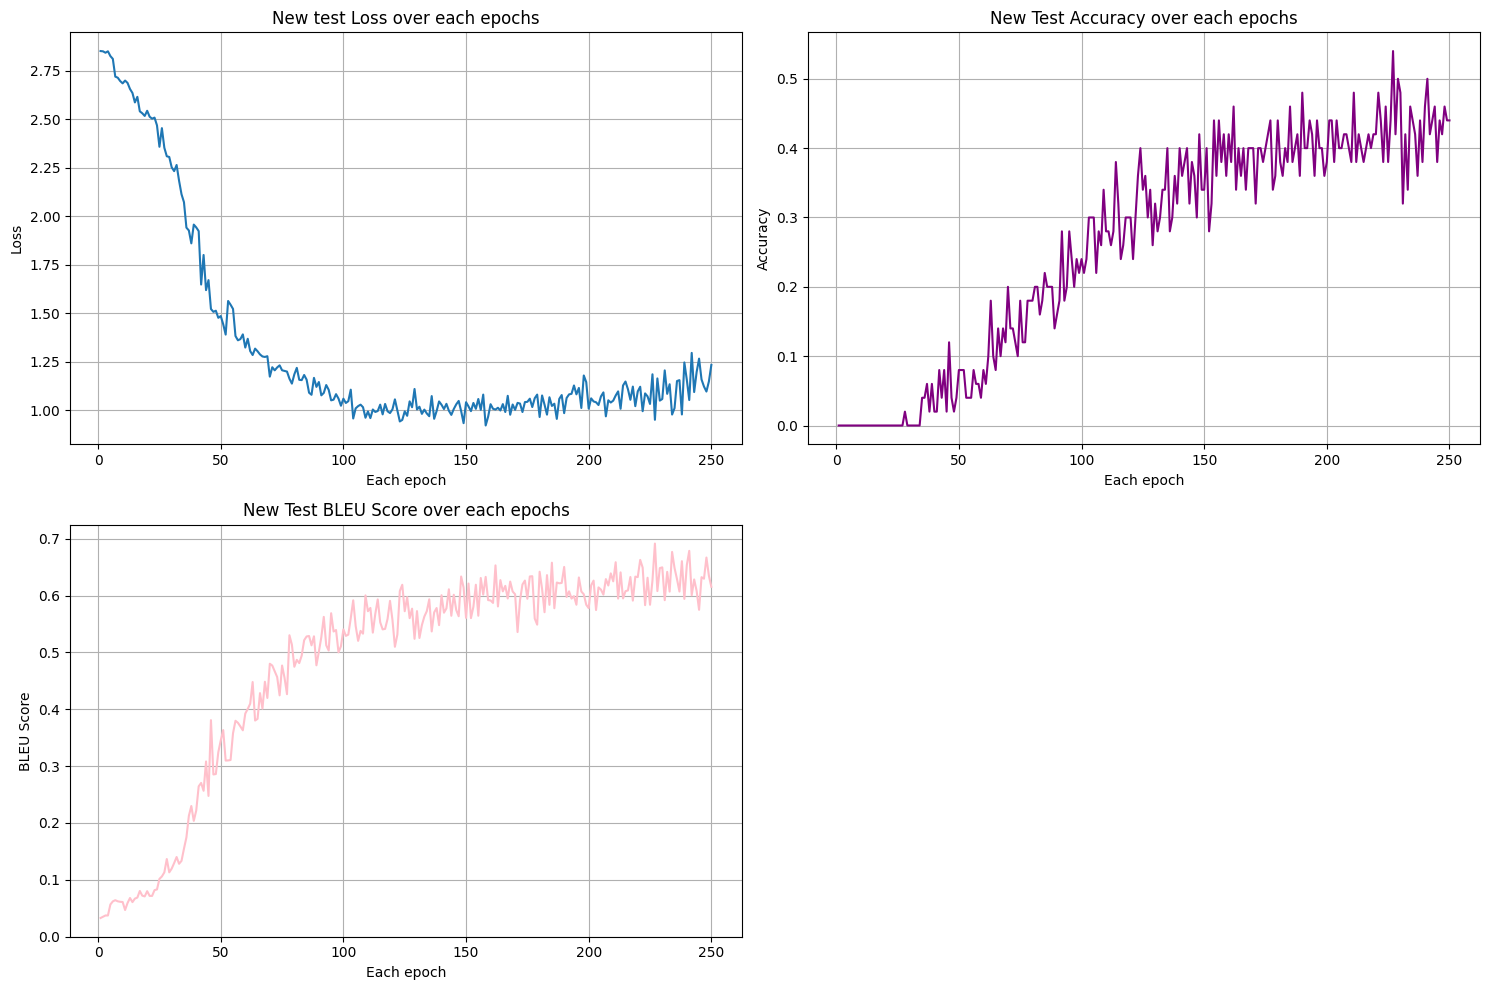

In [32]:
# 第一個表 (Training Loss,Validation Loss)
plt.figure(figsize=(15, 10))
n_loss = [round(num, 5) for num in n_loss]
plt.subplot(2, 2, 1)
plt.plot(range(1, len(n_loss) + 1), n_loss, linestyle='-',label='Training Loss')
plt.xlabel('Each epoch')
plt.ylabel('Loss')
plt.title('New test Loss over each epochs')
plt.grid()

# 第二個表 (Test Accuracy)
plt.subplot(2, 2, 2)
plt.plot(range(1, len(new_accuracy) + 1), new_accuracy, linestyle='-', color='purple')
plt.xlabel('Each epoch')
plt.ylabel('Accuracy')
plt.title('New Test Accuracy over each epochs')
plt.grid()

# 第三個表 (Test BLEU)
plt.subplot(2, 2, 3)
plt.plot(range(1, len(new_blue_score) + 1), new_blue_score, linestyle='-', color='pink')
plt.xlabel('Each epoch')
plt.ylabel('BLEU Score')
plt.title('New Test BLEU Score over each epochs')
plt.grid()

plt.tight_layout()  # 自動調整子圖的間距，防止重疊
plt.show()

In [24]:
def testdata(model, testloader, criterion):
    model.eval()
    epoch_loss = 0
    bleu_score = []
    acc = 0
    with torch.no_grad():
        for i, data in enumerate(testloader):
            src , trg = data[0].to(device) , data[1].to(device)
            output = model(src ,trg , 0)
            output_dim = output.shape[-1]
            src_c = index_to_char1(src)
            trg_c = index_to_char1(trg)
            output_c = index_to_char_soft(output)
            for k in range(len(src_c)):
                print('==========')
                print('src:',src_c[k])
                print('output:',output_c[k])
                print('trg',trg_c[k])
                print('==========')
                bleu_score.append(compute_bleu(output_c[k],trg_c[k]))
                if trg_c[k] == output_c[k]:
                    acc+= 1
            output = output[1:].reshape(-1,output_dim)
            trg = trg[1:].reshape(-1)
            loss = criterion(output, trg)
            epoch_loss += loss.item()
    return acc/50,np.mean(bleu_score),epoch_loss / len(valloader)

In [25]:
model.load_state_dict(torch.load('acc.pt'))
test_acc,test_bleu,test_loss = testdata(model, valloader, criterion)
print(f'\tBLEU SCORE : {test_bleu:.3f} | Accuracy: {test_acc*100: .3f}%')

src: contenpted
output: contented
trg contented
src: begining
output: beginning
trg beginning
src: problam
output: problem
trg problem
src: dirven
output: driven
trg driven
src: ecstacy
output: ecstasy
trg ecstasy
src: juce
output: juice
trg juice
src: localy
output: locally
trg locally
src: compair
output: compare
trg compare
src: pronounciation
output: pronunciation
trg pronunciation
src: transportibility
output: transportability
trg transportability
src: miniscule
output: miniscule
trg minuscule
src: independant
output: independent
trg independent
src: aranged
output: araanged
trg arranged
src: poartry
output: poartry
trg poetry
src: leval
output: level
trg level
src: basicaly
output: basically
trg basically
src: triangulaur
output: triangular
trg triangular
src: unexpcted
output: unexpected
trg unexpected
src: stanerdizing
output: standardizing
trg standardizing
src: varable
output: variable
trg variable
src: neigbours
output: neighbours
trg neighbours
src: enxt
output: next
trg ne

In [30]:
model.load_state_dict(torch.load('acc.pt'))
test_acc,test_bleu,test_loss = testdata(model, testloader, criterion)
print(f'\tBLEU SCORE : {test_bleu:.3f} | Accuracy: {test_acc*100: .3f}%')

src: apreciate
output: appreciate
trg appreciate
src: appeciate
output: appreciate
trg appreciate
src: apprciate
output: approximate
trg appreciate
src: apprecate
output: appreciate
trg appreciate
src: apprecite
output: appreciate
trg appreciate
src: luve
output: love
trg love
src: culd
output: suld
trg cold
src: heart
output: hear
trg heart
src: televiseon
output: television
trg television
src: thone
output: phone
trg phone
src: phace
output: phace
trg phase
src: poam
output: poemions
trg poem
src: tomorraw
output: tomorrow
trg tomorrow
src: presishan
output: presistion
trg precision
src: presishion
output: presistion
trg precision
src: presisian
output: presistion
trg precision
src: presistion
output: presistion
trg precision
src: perver
output: prever
trg prefer
src: predgudice
output: preduggane
trg prejudice
src: predgudis
output: predugries
trg prejudice
src: recievor
output: receiver
trg receiver
src: reciover
output: receiver
trg receiver
src: relieve
output: relieve
trg relief